## 20251971 - Bayan Nezamabad, 21321302 - Sam Ennis, 21308128 - Milan Kovacs
## Execution runs to end without error

## 1. Why Reinforcement Learning for the task of playing Atari games?
Reinforcement learning is a branch of Machine Learning that is used to make a sequence of decision, by interacting the agent (the model) with its environment. The idea behind reinforcement learning is to mimic human learning, where the agent learns from the consequences of its action. This can help the agent make decisions from positive and negative experience. (Hou, 2023)

Video games overtime have became more advanced, where the state space is quite large due to a minor change in the environment. This makes it difficult for traditional methods to solve the game. Rule-based agents restrict the flexibility and it struggles to react to change. Reinforcement Learning forces the agent to figure out with experience the function of best fit and make decisions based on experience. (Hou, 2023)

Due to the complexity of the environment, Reinforcement Learning is a good paradigm for solving the Demon Attack, in the Atari 2600. [1]


## 2. The Gym Environment
### 2.1 Setup


In [1]:
from packaging import version
import tensorflow as tf
import sys
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
# Make sure its running on GPU
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

We downgrade our Atari version from 1.0.0 tp 0.29.1

The If statement checks the environment of running the application, whether it is in Google Colab or local.

In [ ]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install gymnasium[atari]==0.29.1
    %pip install gymnasium[classic_control,box2d,accept-rom-license,ActionWrapper]==0.29.1
else:
    !pip install -q -U gymnasium swig
    !pip install gymnasium[atari]==0.29.1
    !pip install gymnasium[classic_control,box2d,accept-rom-license]==0.29.1

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0


In [ ]:
# Verify installation
import gymnasium as gym
sorted(gym.envs.registry.keys())[:5] + ["..."]

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

### 2.2 The Game - Demon Attack
We will apply DQN learning to Demon Attack. We will be using the Deterministic version which is deterministically skips every 4th frame. Rather than using the standard version, where the frame skipping is inconsistent. This should make learning a bit more reliable with the removal of the random event.  
We chose the RGB version over the RAM version because we thought it better represented how a human would learn to play the game and a human wouldn't have access to the exact RAM information and instead uses visual cues to determine what actions to take, which is how we want our agent to learn.  
#### About the environment
The environment consists of tuple of two objects:
- The state observation
- Info object
#### The state
The state is a 2D array of the 3 pixel channel arrays: list([R, G, B], ...)  
Each pixel has a value from 0 - 255 representing the intensity of the colour. The resolution is 210 x 160.
#### Info dictionary
The info dictionary contains 4 elements, the lives counter, episode_frame_number, frame_number, seeds. We will be extracting the lives value to punish the agent for losing a life/losing the game. [2]

In [ ]:
env = gym.make('DemonAttackDeterministic-v4', render_mode="rgb_array")
obs = env.reset(seed=SEED)
obs

(array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148],
         ...,
         [  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148]],
 
        [[  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148],
         ...,
         [  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148]],
 
        [[  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148],
         ...,
         [  0,   0, 148],
  

In [ ]:
img = env.render()
img.shape

C:\ProgramData\anaconda3\envs\tf\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


(210, 160, 3)

### 2.3 Evaluation of the frame
The frames are rendered in 210 by 160 pixels, through 3 channels (RGB).

The game consists of a platform represented by the blue rectangle on the bottom.
The agent is the purple ship on the bottom. It can move left and right, and fire a bullet, represented by the purple vertical line in the picture.
The enemies can spawn in at random points and fly around. Each demon will shoot bullets that will kill the player upon hitting the player. There are three main types of demons.
- Demons: These demons fly around, shoot bullets and die upon being shot.
- Split Demons: Similar to regular demons however they split into two demons after being shot, one of the split demons will continue to shoot down at the player.
- Diving Demons: These demons will float down towards the player and will kill the player upon impact.

The player can shoot purple bullets that move upwards and kill demons upon impact. [3]

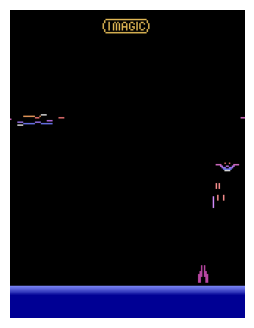

In [ ]:
import matplotlib.pyplot as plt

def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img

plot_environment(env)
plt.show()

### 2.4 The inputs
There are 6 inputs in the game, can as shown by the first number in the cell below.  
The 6 actions maps from 0 to 5 with the moves: Noop, Fire, Right, Left, Right and Fire, Left and fire respectively. [2]

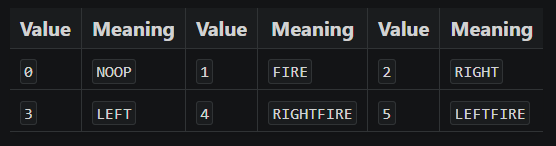  
<i>Image source: https://gymnasium.farama.org/v0.28.1/environments/atari/demon_attack/ </i>

In [ ]:
n_actions = env.action_space.n
input_shape = env.observation_space.shape

print(n_actions)
print(input_shape)

6
(210, 160, 3)


source: https://atariage.com/manual_html_page.php?SoftwareLabelID=588

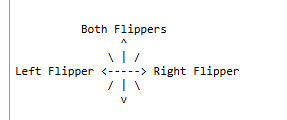

## 3. Implementation
Here we will discuss the following:
- Architecture
- Preprocessing
- Exploration vs Exploitation
- Fixed agent Q-learning
- Update strategy and error calculation

### 3.1 Architecture
We have a convolutional neural network (CNN) followed by a fully connected layers. See the function <b><i>build_model</b></i>.

The architecture is the following: 
- The input is going to be a stack of 4 frames (84x84x4), each frame preprocessed to be a greyscale square frame (1 colour channel with resolution 84x84). Followed by batch normalisation.
- Convolutional layer with 32 filters, kernel size of 2x2, stride of 2, and ReLU activation. Followed by batch normalisation.
- Convolutional layer with 64 filters, kernel size of 3x3, stride of 1, and ReLU activation. Followed by batch normalisation.
- A flattening layer before the first fully-connected layer with 32 units and ReLU activation.
- A final fully-connected layer with 6 units (the number of actions in the environment) and linear activation.

Other architectures we tried included convolutional layers such as: 
- 32 filter, kernel size of 8x8, stride of 4, and ReLU activation
- 64 filter, kernel size of 4x4, stride of 2, and ReLU activation
- 64 filter, kernel size of 3x3, stride of 1, and ReLU activation

We ended up keeping the architecture simple and opting for smaller kernels for our convolutional layers as we want to be able to extract relevant features from the screen effectively and such features such as player/enemy bullets can be very small.  
Batch normalisation is used directly after the input layer hence no normalisation of this layer is carried out beforehand.

### 3.2 Preprocessing
We wanted to reduce the complexity of the input as the initial dimensions are large (210x160x3). See the function <i><b>preprocess_state</b></i>.

First we change all frames to have 1 channel by converting them to be grayscale. We do this as we don't see much added value in the colour to justify the extra processing required. The main thing is for the model to learn enemies, the player and the bullets they shoot, and this is better determined by their location on the screen, their shape, and in the case of the bullets, the direction they move in.

We also simplified the resolution down to a square 84x84 image using the nearest neighbour method. The final image is a 84x84 square. This allows us to lower the dimensions while retaining the relevant features the model will need to learn.

Below is an example of an original frame and a preprocessed frame resized to 84x84 using the nearest neighbour method (and in grayscale).  
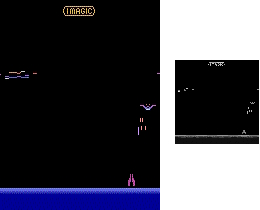

### 3.3 Exploration Vs Exploitation
For any agent to learn optimal play it first needs to explore possible strategies by taking random moves and observing the reward that gives. From this exploration the agent learns what moves give the most reward and in turn, will learn to play effectively to maximise reward (exploitation).

We had the strike a balance between exploration and exploitation so that we could try various ways to help our model train while also being able to examine how it performs by having it perform exploitative moves.

We chose an initial epsilon of 1 to facilitate exploration and a decay rate of 0.99 so that it would decay by 1% each episode. After 100 episodes you would end up with an epsilon of about 0.36. We often ran our model for 50 episodes, and after 35 episodes, drastically lower the epsilon to about 0.4 to examine how the agent performs when exploitative moves are more frequent than exploratory moves. This allowed us to run experiments without it taking a prohibitively long time to see results of those experiments.

Exploitative moves are chosen by taking the move that is most likely to give the most reward according to what the model has learned.  
Exploratory moves are chosen at random.

### 3.4 Fixed Agent Q-Learning
We are using a fixed agent Q-learning approach to minimize the catastrophic forgetting. Fixed Q-Learning consists of using two models, an online agent and a fixed agent.
The online model continuously plays and updates its weights from the Q-learning. The fixed agent makes the decision for the online agent, and the fixed agent copies the online agent's weights every N number of episodes. We went with N=10, meaning every 10th episode we update the fixed agent's weights. 

This should prevent the agent from catastrophic forgetting, and make it more stable. 

The modifications to the code to include fixed Q-learning are:
- Line 44-45 Constructor: Added fixed agent and copied the starting weights 
- Line 81 choose_action: 

### 3.5 Update Strategy and Error Calculation
The update occurs in the replay function.
```python  
def replay(self):
    minibatch, indices = self.sample_from_memory() # Get experiences from memory
    if not minibatch:
        # If there is not enough experiences in memory, return
        return

    states = []
    targets = []

    for _, state, action, reward, next_state, done in minibatch:
        state_input = tf.expand_dims(state, axis=0)
        next_state_input = tf.expand_dims(next_state, axis=0)
        q_values = self.model.predict(state_input, verbose=0)

        if done:
            # If the episode is done, award the final reward
            q_values[0][action] = reward
        else:
            # Else, calculate the Q-value for the next using the Bellman equation 
            q_values_next = self.model.predict(next_state_input, verbose=0)
            q_values[0][action] = reward + self.gamma * np.max(q_values_next[0])

        # Add the state and target to the lists
        states.append(state)
        targets.append(q_values[0])

    # Fit the model with the states
    self.model.fit(np.array(states), np.array(targets), batch_size=self.batch_size, verbose=0)
    self.update_priorities(minibatch, indices) # Update the priorities

def sample_from_memory(self):
    if len(self.memory) < self.batch_size:
        return []
    priorities = np.array([exp[0] for exp in self.memory])
    probabilities = priorities / (np.sum(priorities) + 1e-8)
    probabilities = np.clip(probabilities, 0, 1)
    probabilities /= np.sum(probabilities)  # Re-normalize after clipping

    indices = np.random.choice(len(self.memory), self.batch_size, p=probabilities)
    experiences = [self.memory[i] for i in indices]
    return experiences, indices
```

> Q(s,a)=r+γ⋅max(Q(s′,a′))

In [ ]:
# Imports
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

# Set seed to replication
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# We are using DemonAttack Deterministic
# This skips every fourth frame/tick
# We are using the pixels in the environment to learn as we believe it best mimics a human learning to play
env_string = 'DemonAttackDeterministic-v4'

# DQN class
class DQN():
  def __init__(self,
               env_string,
               batch_size=64):
    self.memory = deque(maxlen=100_000)
    self.env = gym.make(env_string)

    # Stacked frames => input shape with 4 frames in the depth dimension
    input_size = (84, 84, 4)
    action_size = self.env.action_space.n # The 6 operations the player can execute each frame

    print(f'self.env.observation_space = {self.env.observation_space}')
    print(f'input_size = {input_size}')
    print(f'action_size = {action_size}')

    self.batch_size = batch_size
    self.gamma = 0.99
    self.epsilon = 1.0 # Chance of choosing an exploratory move
    self.epsilon_min = 0.01 # The minimum epsilon value. However, we did not run our agents for enough episodes to reach this value
    self.epsilon_decay = 0.99 # Proportion of epsilon to use each subsequent episode
    alpha=0.01 # Learning rate

    self.build_model(input_size, action_size, alpha)
    self.fixed_agent = tf.keras.models.clone_model(self.model)
    self.fixed_agent.set_weights(self.model.get_weights())

  def build_model(self, input_shape, n_actions, alpha):
    # Initialise the model
    self.model = Sequential()
    # Add the input layer (84x84x4)
    self.model.add(Input(shape=input_shape))
    # Normalise the input
    self.model.add(BatchNormalization())
    # Convolutional layers. Small kernel to help detect small features. Stride two halves the resolution.
    self.model.add(Conv2D(32, (2, 2), strides=2, activation='relu'))
    self.model.add(BatchNormalization())
    # A slightly larger kernel, and stride 1 to retain the same resolution.
    self.model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
    self.model.add(BatchNormalization())

    # Fully connected layers
    self.model.add(Flatten())
    self.model.add(Dense(32, activation='relu'))
    # Six units to represent each action the player can execute
    self.model.add(Dense(n_actions, activation='linear'))

    # Compile the model and specify the loss function, optimiser, and learning rate
    self.model.compile(loss = 'mse', optimizer=Adam(learning_rate = alpha))

  # Add the step to memory
  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  # Epsilon greedy strategy
  def choose_action(self, state):
    if np.random.random() <= self.epsilon:
      # Randomly choose a random (exploratory) move based on epsilon
      # Epsilon is the chance of choosing an exploratory move
      return self.env.action_space.sample()
    else:
      # Otherwise choose an exploitative move
      # From our model's predictions we choose what it thinks is most likely to be the optimal move
      # The fixed agent is going to make the decision for our online agent
      return np.argmax(self.fixed_agent.predict(state, verbose=0)) 

  # Preprocessing the state to reduce computation as we are using the resolution of the game (210x160x3)
  def preprocess_state(self, state):
      if len(state) == 2:
        img = state[0]
      else:
        img = state
      # Reduce the number of channels from 3 to 1 as colour is unlikely to have a big effect on performance
      img = tf.image.rgb_to_grayscale(img)
      # Scaling down the image to a more manageable size
      img = tf.image.resize([img], [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      img = tf.cast(img, tf.float32)
      return img

  def replay(self, batch_size):
    if len(self.memory) < batch_size:
      return

    x_batch, y_batch = [], []
    minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
    for state, action, reward, next_state, done in minibatch:
      y_target = self.model.predict(state, verbose=0)
      y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state, verbose=0)[0])
      x_batch.append(state[0])
      y_batch.append(y_target[0])

    self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)

  def train(self, epochs = 50):
    scores = deque(maxlen=100)
    avg_scores = []
    self.scores = []
    self.decays = []
    frame_cap = 2_000
    for episode in range(epochs):
      state, info = self.env.reset()
      self.lives_remaining = info.get('lives', 1)

      state = self.preprocess_state(state)
      done = False
      # Score is no. of ticks survived
      score = 0
      frame_count = 0
      while not done:
        action = self.choose_action(state)
        next_state, reward, done, _, info = self.env.step(action)
        next_state = self.preprocess_state(next_state)

        # Punish agent for losing a life
        current_lives = info.get('lives')
        if current_lives < self.lives_remaining:
            print("Life lost")
            reward -= 500
            self.lives_remaining = current_lives

        self.remember(state, action, reward, next_state, done)
        state = next_state
        score += reward

        frame_count += 1

        if frame_count >= frame_cap:
          print(f"Frame cap has been reached: {frame_cap} frames for episode {episode + 1}")
          break

      scores.append(score)
      self.scores.append(score)
      mean_score = np.mean(scores)
      avg_scores.append(mean_score)
      self.decays.append(self.epsilon)
      print(f'Episode {episode+1}/{epochs} complete, score: {score}, epsilon: {np.round(self.epsilon, 4)}')
      if (episode+1) % 20 == 0:
        print(f'[Episode {episode+1}] - Mean survival time over last 20 episodes was {mean_score} ticks.')

      if ((episode + 1) % 10) == 0:
        print(f'Updating target Agent for epside {episode + 1} onwards')
        self.fixed_agent.set_weights(self.model.get_weights())

      if (episode) == 35:
        self.epsilon = 0.40

      self.replay(self.batch_size)
      # Decrease epsilon after each episode to gradually shift from random to learned actions
      self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon)

    return avg_scores


agent = DQN(env_string)

# agent.model.summary()

self.env.observation_space = Box(0, 255, (210, 160, 3), uint8)
input_size = (84, 84, 1)
action_size = 6


In [ ]:
avg_scores = agent.train()

Life lost
Episode 1/50 complete, score: -400.0, epsilon: 1.0
Life lost
Episode 2/50 complete, score: -325.0, epsilon: 0.99
Life lost
Episode 3/50 complete, score: -430.0, epsilon: 0.9801
Frame cap has been reached: 2000 frames for episode 4
Episode 4/50 complete, score: 150.0, epsilon: 0.9703
Life lost
Episode 5/50 complete, score: -360.0, epsilon: 0.9606
Life lost
Episode 6/50 complete, score: -370.0, epsilon: 0.951
Life lost
Episode 7/50 complete, score: -145.0, epsilon: 0.9415
Frame cap has been reached: 2000 frames for episode 8
Episode 8/50 complete, score: 370.0, epsilon: 0.9321
Life lost
Episode 9/50 complete, score: -235.0, epsilon: 0.9227
Life lost
Episode 10/50 complete, score: -360.0, epsilon: 0.9135
Updating target Agent for epside 10 onwards
Life lost
Episode 11/50 complete, score: -280.0, epsilon: 0.9044
Life lost
Episode 12/50 complete, score: -175.0, epsilon: 0.8953
Life lost
Episode 13/50 complete, score: -380.0, epsilon: 0.8864
Life lost
Episode 14/50 complete, score:

## 4. Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load scores from scores.npy
avg_scores = np.load('scores.npy')

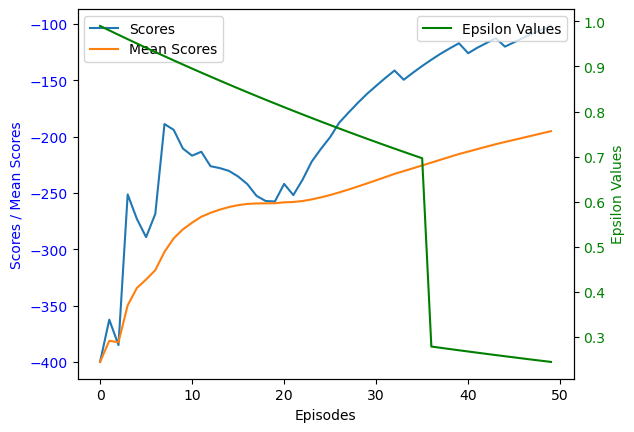

In [ ]:
agent.model.save('dqn_model.h5')
np.save('scores.npy', scores)

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

## 5. Gameplay videos

In [ ]:
# Sauce: https://colab.research.google.com/github/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb#scrollTo=GT0x6sxhjrhf
import matplotlib.pyplot as plt
import matplotlib.animation as animation

name_of_video = "Demon_Attack_play_one_episode.mp4"

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    anim.save('episode_video.mp4', writer="ffmpeg", fps=15)
    print(f"Saved video to {name_of_video}")
    plt.close()
    return anim

def show_open_episode(agent, seed = 42):
    frames = []
    frame_cap = 10_000
    agent.env = gym.make("DemonAttackDeterministic-v4", render_mode="rgb_array")
    for episode in range(1):
        state, info = agent.env.reset(seed=SEED)
        agent.current_lives = info.get('info', 1)
        state = agent.preprocess_state(state)
        done = False
        score = 0
        frame_count = 0
        while not done:
            frame = agent.env.render()
            frames.append(frame)
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = agent.env.step(action)
            next_state = agent.preprocess_state(next_state)     

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            score += reward

            frame_count += 1

            if frame_count >= frame_cap:
                print(f"Frame cap has been reached: {frame_cap} frames for episode {episode + 1}")
                break
    agent.env.close()
    return plot_animation(frames)

show_open_episode(agent)

C:\ProgramData\anaconda3\envs\tf\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Frame cap has been reached: 2000 frames for episode 1


## 6. Evaluation of the results

## 7. References
[1] Hou, X., 2023, November. Exploring the Role of Reinforcement Learning in Video Game Environments. In 2023 International Conference on Image, Algorithms and Artificial Intelligence (ICIAAI 2023) (pp. 193-201). Atlantis Press.  
[2] [Gymnasium documentation for DemonAttack](https://gymnasium.farama.org/v0.28.1/environments/atari/demon_attack/)  
[3] [AtariAge documentation for DemonAttack](https://atariage.com/manual_html_page.php?SoftwareLabelID=135)